# Awareness Modeling


In [171]:
%matplotlib inline
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
from scipy import sparse, stats, spatial

from sklearn.decomposition import NMF, LatentDirichletAllocation


## Import the features from different pickles : 

In [248]:
c_data = pickle.load(open('../DataEnriching/data.pickle','rb'))

lang_feature_df = pd.read_pickle('../LinkingLanguages/stand_country_dist_languages.pkl')
fligh_routes_df = pd.read_pickle('../GeoMetrics/flight_routes.pickle')
hop_distance_df = pd.read_pickle('../GeoMetrics/hop_distance.pickle')
neighbor_influence_df = pd.read_pickle('../GeoMetrics/neighbor_influence.pickle')
dist_feature_df = pd.read_pickle('../GeoMetrics/real_distance.pickle')
religion_and_more_df = pd.read_pickle('../DataEnriching/Pickles for Milestone 3/6_feature_df.pickle')

# drop the name column : 
religion_and_more_df.drop('name',axis=1,inplace=True)

# shift the normalized values :
lang_feature_df = lang_feature_df - lang_feature_df.min().min()
fligh_routes_df = fligh_routes_df - fligh_routes_df.min().min()
hop_distance_df = hop_distance_df - hop_distance_df.min().min()
neighbor_influence_df = neighbor_influence_df - neighbor_influence_df.min().min()
dist_feature_df = dist_feature_df - dist_feature_df.min().min()
religion_and_more_df = religion_and_more_df - religion_and_more_df.min().min()

#carefull the number of coutries is not the same in every pickle.
features_df = pd.concat([lang_feature_df,
           fligh_routes_df,
           hop_distance_df,
           neighbor_influence_df,
          dist_feature_df,
          religion_and_more_df],axis=1)
# convert every Nan to a 0 
features_df.fillna(1E5,inplace=True)
# replace inf by a large number :
features_df.replace(np.inf, 1E5,inplace=True)



features_df.index.is_unique

/Users/adrian/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:11: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.


True

## Applying the NMF

In [249]:
features_mat = features_df.as_matrix()

In [252]:
n_samples = np.shape(features_mat)[1]
n_features = 1000
n_components = round(np.shape(features_mat)[1])

In [253]:
W = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit_transform(features_mat)

In [254]:
np.shape(W)

(248, 1256)

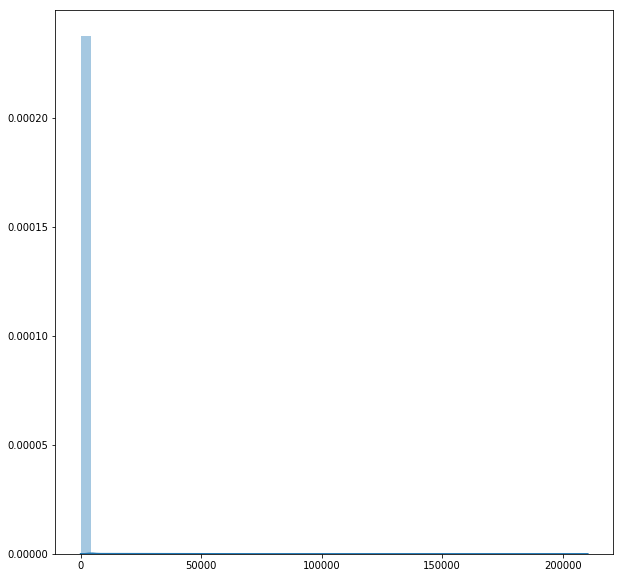

In [255]:
plt.figure(figsize=[10,10])
sns.distplot(W.flatten())

## Weight Matrix and Graph

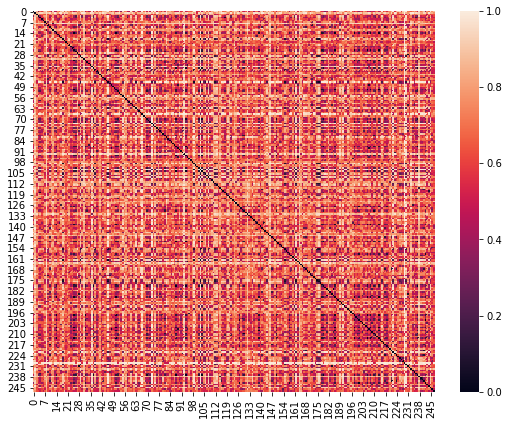

In [256]:
distances = spatial.distance.squareform(spatial.distance.pdist(W,'cosine')) # W
plt.figure(figsize=[9,7])
sns.heatmap(distance)

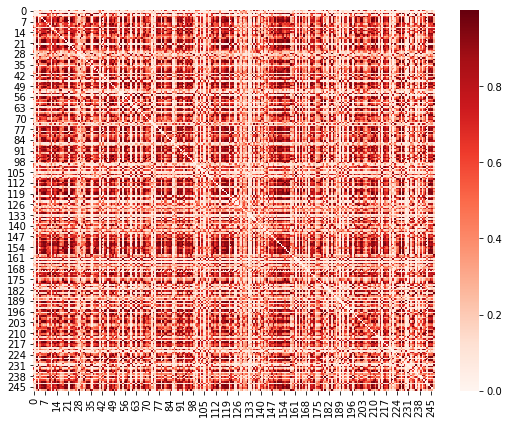

In [257]:
kernel_width = np.mean(distances)#distances.mean()

def kernel(x):
    return np.exp(- np.power(x/kernel_width,2))

# applying the kernel to the distances matrix :
weights = kernel(distances)
# setting the diagonal (self-loops) weights to 0 :
weights[range(len(weights)),range(len(weights))] = 0

# displaying a subset of the weights matrix :
plt.figure(figsize=[9,7])
sns.heatmap(weights,cmap="Reds")

In [258]:
weights_df = pd.DataFrame(weights,columns=c_data.index,index=c_data.index)

In [260]:
weights_df['United States'].loc[weights_df['United States'] >= 0.8]

name
Libya           0.818095
Saint Martin    0.851059
North Korea     0.858783
Name: United States, dtype: float64